In [1]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")



## Reading the data

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
train.dropna(inplace=True) #since there is one null

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## EDA

In [7]:
train.drop(["textID", "selected_text"], axis = 1, inplace = True)
test.drop(["textID"], axis = 1, inplace = True)

In [8]:
test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [9]:
## Distribution of tweets
temp = train.groupby("sentiment").count()['text'].reset_index().sort_values("text", ascending = False)
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='text'>

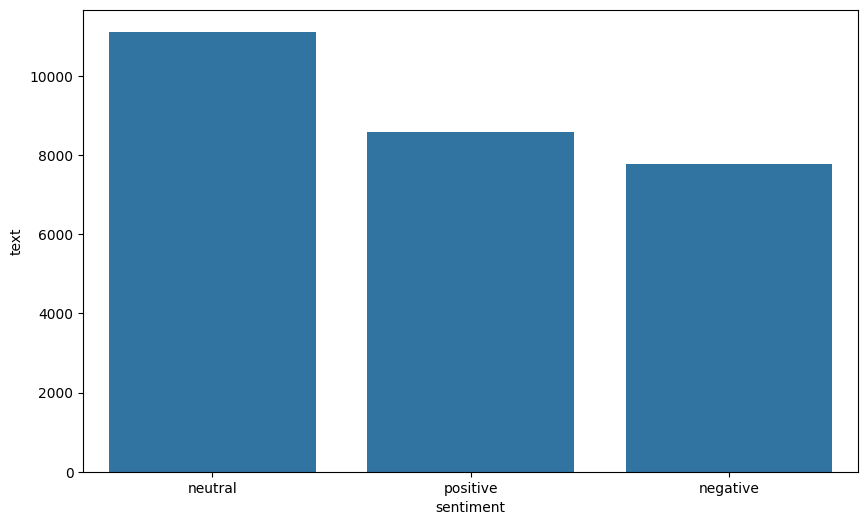

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x="sentiment", y="text", data=temp)

## Generating Meta-Features
* Length of text
* Number of words
* Average word length
* Numnber of sentences
* Exclamation count
* Question count
* Capital letters count

In [11]:
df = train
nltk.download('vader_lexicon')
df["Length of text"] = df["text"].apply(lambda x:len(x))
df["Num Words"] = df["text"].apply(lambda x:len(str(x).split()))
df["Average Word Length"] = df["text"].apply(lambda x:np.mean([len(word) for word in str(x).split()]))
df["Exclamation count"] = df["text"].apply(lambda x : x.count("!"))
df["Question count"] = df["text"].apply(lambda x : x.count("?"))
df["Capital letters count"] = df["text"].apply(lambda x : sum(1 for c in x if c.isupper()))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [12]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
# Function to extract sentiment features
def extract_sentiment_features(text):
    # VADER sentiment analysis
    vader_scores = sid.polarity_scores(text)
    # TextBlob sentiment analysis
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    return pd.Series({
        'vader_positive': vader_scores['pos'],
        'vader_neutral': vader_scores['neu'],
        'vader_negative': vader_scores['neg'],
        'vader_compound': vader_scores['compound'],
        'textblob_polarity': polarity,
        'textblob_subjectivity': subjectivity
    })

# Apply the function to each row in the 'text' column
sentiment_features = df['text'].apply(extract_sentiment_features)

# Merge the sentiment features with the original dataset
df = pd.concat([df, sentiment_features], axis=1)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
train_meta = df
train_meta.head()

,text,sentiment,Length of text,Num Words,Average Word Length,Exclamation count,Question count,Capital letters count,vader_positive,vader_neutral,vader_negative,vader_compound,textblob_polarity,textblob_subjectivity
0,"I`d have responded, if I were going",neutral,36,7,4.142857,0,0,2,0.0,1.000,0.000,0.0000,0.000000,0.0
1,Sooo SAD I will miss you here in San Diego!!!,negative,46,10,3.600000,3,0,7,0.0,0.526,0.474,-0.7437,-0.976562,1.0
2,my boss is bullying me...,negative,25,5,4.200000,0,0,0,0.0,0.506,0.494,-0.5994,0.000000,0.0
3,what interview! leave me alone,negative,31,5,5.200000,1,0,0,0.0,0.462,0.538,-0.3595,0.000000,0.0
4,"Sons of ****, why couldn`t they put them on t...",negative,75,14,4.357143,0,0,1,0.0,1.000,0.000,0.0000,0.000000,0.0


## Basic Cleaning

In [14]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train_meta['text'] = train_meta['text'].apply(lambda x:clean_text(x))


In [15]:
train_meta.head()

,text,sentiment,Length of text,Num Words,Average Word Length,Exclamation count,Question count,Capital letters count,vader_positive,vader_neutral,vader_negative,vader_compound,textblob_polarity,textblob_subjectivity
0,id have responded if i were going,neutral,36,7,4.142857,0,0,2,0.0,1.000,0.000,0.0000,0.000000,0.0
1,sooo sad i will miss you here in san diego,negative,46,10,3.600000,3,0,7,0.0,0.526,0.474,-0.7437,-0.976562,1.0
2,my boss is bullying me,negative,25,5,4.200000,0,0,0,0.0,0.506,0.494,-0.5994,0.000000,0.0
3,what interview leave me alone,negative,31,5,5.200000,1,0,0,0.0,0.462,0.538,-0.3595,0.000000,0.0
4,sons of why couldnt they put them on the rel...,negative,75,14,4.357143,0,0,1,0.0,1.000,0.000,0.0000,0.000000,0.0


## Distribution of length of text

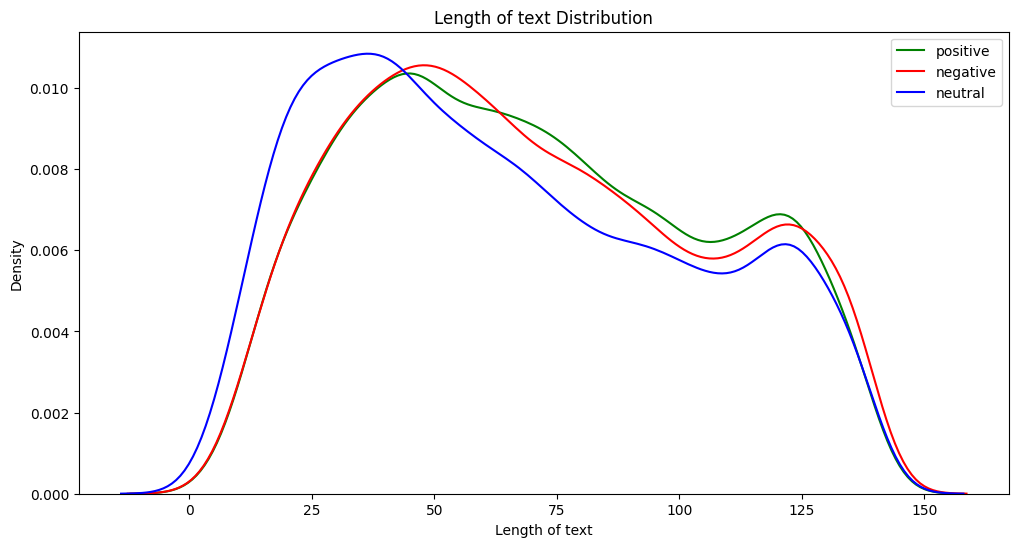

In [16]:
plt.figure(figsize=(12,6))
name = train_meta.columns[2]
sns.kdeplot(train_meta[train_meta["sentiment"] == "positive"][name], shade=False, color="g", label = "Positive").set_title(name+' Distribution')
sns.kdeplot(train_meta[train_meta["sentiment"] == "negative"][name], shade=False, color="r", label = "Negative")
sns.kdeplot(train_meta[train_meta["sentiment"] == "neutral"][name], shade=False, color="b", label = "Neutral")
plt.legend(labels=['positive','negative', "neutral"])


## Distribution of Number of words

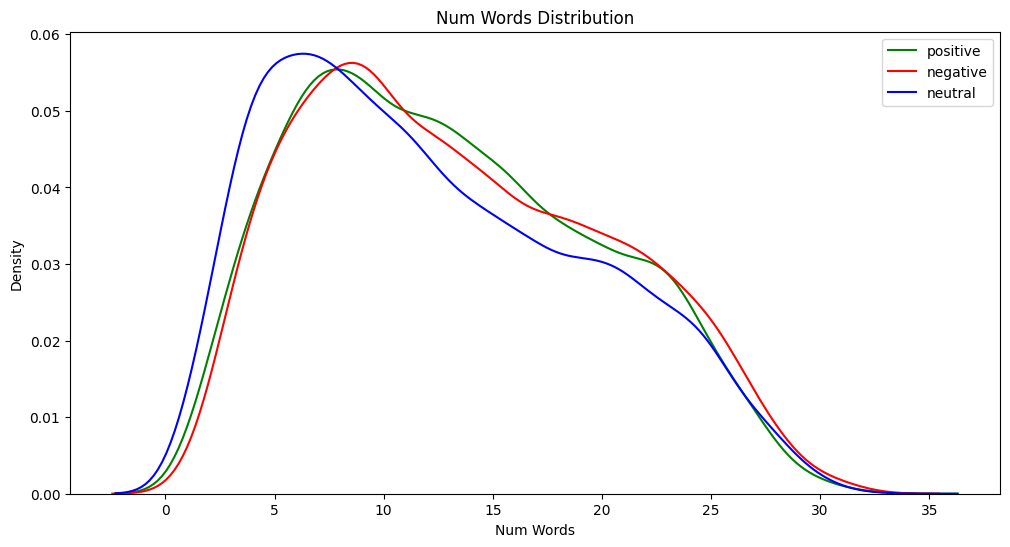

In [17]:
plt.figure(figsize=(12,6))
name = train_meta.columns[3]
sns.kdeplot(train_meta[train_meta["sentiment"] == "positive"][name], shade=False, color="g", label = "Positive").set_title(name+' Distribution')
sns.kdeplot(train_meta[train_meta["sentiment"] == "negative"][name], shade=False, color="r", label = "Negative")
sns.kdeplot(train_meta[train_meta["sentiment"] == "neutral"][name], shade=False, color="b", label = "Neutral")
plt.legend(labels=['positive','negative', "neutral"])


## Average word length distribution

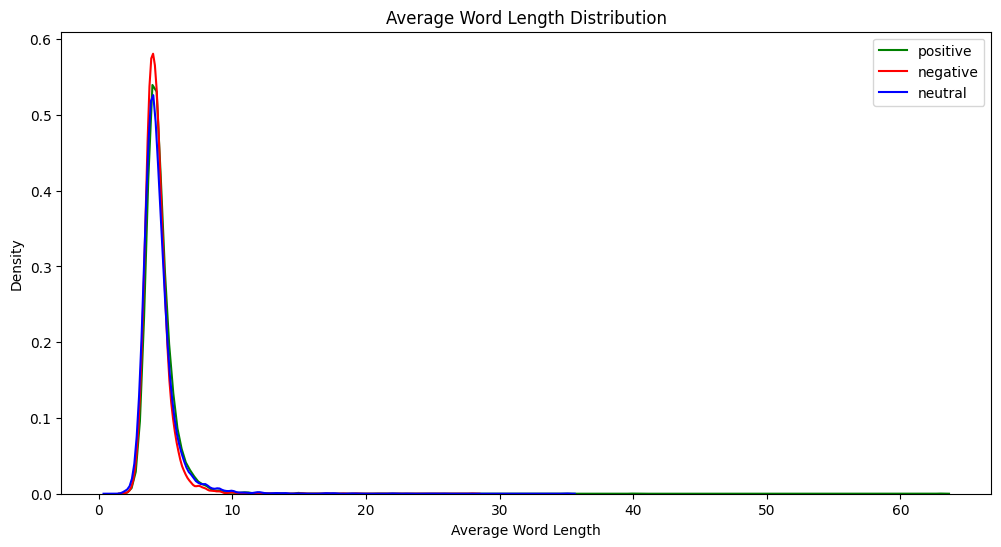

In [18]:
plt.figure(figsize=(12,6))
name = train_meta.columns[4]
sns.kdeplot(train_meta[train_meta["sentiment"] == "positive"][name], shade=False, color="g", label = "Positive").set_title(name+' Distribution')
sns.kdeplot(train_meta[train_meta["sentiment"] == "negative"][name], shade=False, color="r", label = "Negative")
sns.kdeplot(train_meta[train_meta["sentiment"] == "neutral"][name], shade=False, color="b", label = "Neutral")
plt.legend(labels=['positive','negative', "neutral"])


<Axes: xlabel='sentiment'>

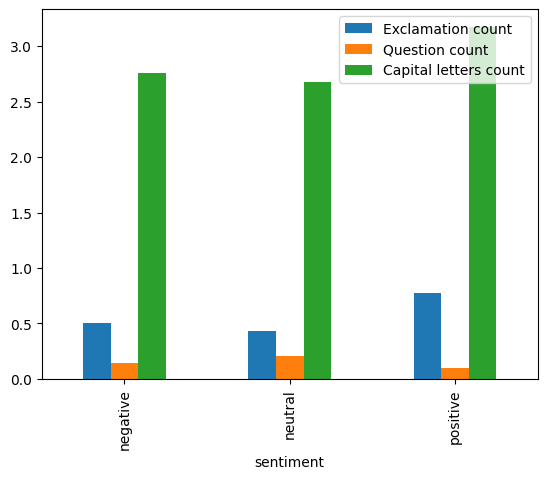

In [22]:
train_meta.groupby("sentiment")[["Exclamation count", "Question count", "Capital letters count"]].mean().plot(kind = "bar")

## Most Common words in our Text

In [26]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def remove_stopword(text):
    '''a function for removing the stopword'''
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

train_meta['text_no_stop_words'] = train_meta['text'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
train_meta.head(2)

,text,sentiment,Length of text,Num Words,Average Word Length,Exclamation count,Question count,Capital letters count,vader_positive,vader_neutral,vader_negative,vader_compound,textblob_polarity,textblob_subjectivity,text_no_stop_words
0,id have responded if i were going,neutral,36,7,4.142857,0,0,2,0.0,1.000,0.000,0.0000,0.000000,0.0,id responded going
1,sooo sad i will miss you here in san diego,negative,46,10,3.600000,3,0,7,0.0,0.526,0.474,-0.7437,-0.976562,1.0,sooo sad miss san diego


## Most common words

In [29]:
train_meta['temp_list'] = train_meta['text_no_stop_words'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_meta['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,im,3020
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,got,1225
7,dont,1200
8,love,1122
9,work,1112


In [30]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [31]:
Positive_sent = train_meta[train_meta['sentiment']=='positive']
Negative_sent = train_meta[train_meta['sentiment']=='negative']
Neutral_sent = train_meta[train_meta['sentiment']=='neutral']

In [32]:
#Most common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,day,1223
1,good,1046
2,love,875
3,happy,840
4,im,740
5,mothers,627
6,thanks,553
7,great,478
8,like,413
9,hope,396


In [33]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,like,476
2,dont,469
3,cant,463
4,get,436
5,miss,422
6,go,401
7,sad,389
8,work,386
9,got,354
10,sorry,340


In [35]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [36]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,623
2,go,576
3,got,527
4,day,503
5,dont,491
6,going,479
7,work,477
8,like,457
9,lol,454
10,today,435


In [37]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [38]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis


In [41]:
train_meta.columns

Index(['text', 'sentiment', 'Length of text', 'Num Words',
       'Average Word Length', 'Exclamation count', 'Question count',
       'Capital letters count', 'vader_positive', 'vader_neutral',
       'vader_negative', 'vader_compound', 'textblob_polarity',
       'textblob_subjectivity', 'text_no_stop_words', 'temp_list'],
      dtype='object')

## Libraries for data modeling

In [60]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier




## Preprocessing test data
* Generate Meta features
* Add sentiment scores
* Clean text
* Remove stop words

In [43]:
df = test
nltk.download('vader_lexicon')
df["Length of text"] = df["text"].apply(lambda x:len(x))
df["Num Words"] = df["text"].apply(lambda x:len(str(x).split()))
df["Average Word Length"] = df["text"].apply(lambda x:np.mean([len(word) for word in str(x).split()]))
df["Exclamation count"] = df["text"].apply(lambda x : x.count("!"))
df["Question count"] = df["text"].apply(lambda x : x.count("?"))
df["Capital letters count"] = df["text"].apply(lambda x : sum(1 for c in x if c.isupper()))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
sentiment_features = df['text'].apply(extract_sentiment_features)

# Merge the sentiment features with the original dataset
df = pd.concat([df, sentiment_features], axis=1)


In [45]:
test_meta = df
test_meta['text'] = test_meta['text'].apply(lambda x:clean_text(x))

In [47]:
test_meta['text_no_stop_words'] = test_meta['text'].apply(lambda x:remove_stopword(x))

In [50]:
X_train = train_meta.drop("sentiment", axis = 1)
y_train = train_meta["sentiment"]
X_test = test_meta.drop("sentiment", axis = 1)
y_test = test_meta["sentiment"]

## Using TF-IDF vectorizer

This pipeline has three steps:

* TF-IDF Vectorization ('tfidf')
* Scaling ('scaler')
* Model ('clf')


1. TF-IDF Vectorization ('tfidf')
Component: TfidfVectorizer(max_features=5000)
Purpose: This step converts the raw text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) method.
How it Works:
Term Frequency (TF): Counts how frequently each word appears in a document.
Inverse Document Frequency (IDF): Measures how important a word is by reducing the weight of words that appear frequently across many documents.
max_features=5000: Limits the vocabulary size to the 5,000 most significant words, making the model faster and more manageable.
Output: A sparse matrix where each row represents a document and each column represents a word's TF-IDF score.

2. Scaling ('scaler')
Component: StandardScaler(with_mean=False)
Purpose: Standardizes the features by scaling them to have a mean of 0 and a standard deviation of 1.
Why Scaling: Some models (e.g., SVMs, Logistic Regression) perform better when the input features are standardized.
Why with_mean=False: TF-IDF matrices are sparse, and centering them (subtracting the mean) would break that sparsity, leading to inefficiency. Setting with_mean=False avoids this problem.
Output: A scaled version of the TF-IDF matrix.

3. Classifier ('clf')
Component: LogisticRegression()
Purpose: This step trains the Logistic Regression model on the scaled features.
How it Works: Logistic Regression is a linear model that estimates the probability of a binary outcome (positive or negative sentiment) by fitting a linear decision boundary.
Output: A trained Logistic Regression model that can make predictions on new data.

How the Pipeline Works Together
Input: When you call fit() on the pipeline, it passes the raw text data through the pipeline.

Step 1: The text is transformed into a TF-IDF matrix.
Step 2: The TF-IDF matrix is scaled.
Step 3: The scaled features are fed into the Logistic Regression model for training.
Prediction: When you call predict() on the pipeline, it follows the same sequence of steps but instead of training, it applies the transformations and uses the trained model to make predictions.

## 1. Logistic Regression

In [51]:
# Pipeline with TF-IDF and Logistic Regression
logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression())
])

logistic_pipeline.fit(X_train['text_no_stop_words'], y_train)
y_pred = logistic_pipeline.predict(X_test['text_no_stop_words'])

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.6375212224108658
              precision    recall  f1-score   support

    negative       0.63      0.62      0.62      1001
     neutral       0.60      0.63      0.61      1430
    positive       0.71      0.67      0.69      1103

    accuracy                           0.64      3534
   macro avg       0.64      0.64      0.64      3534
weighted avg       0.64      0.64      0.64      3534



## 2.Random Forest

In [54]:
# Random Forest Model
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier(n_estimators=100))
])

rf_pipeline.fit(X_train['text_no_stop_words'], y_train)
y_pred = rf_pipeline.predict(X_test['text_no_stop_words'])

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest
Accuracy: 0.7059988681380871
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1001
     neutral       0.66      0.72      0.69      1430
    positive       0.76      0.75      0.75      1103

    accuracy                           0.71      3534
   macro avg       0.71      0.70      0.71      3534
weighted avg       0.71      0.71      0.71      3534



## Adding the Meta features to RF classifier

In [59]:
# Define the text processing pipeline

from sklearn.compose import ColumnTransformer
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000))
])

# Combine text transformer with meta features using ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_transformer, 'text_no_stop_words'),  # Apply TF-IDF only to 'text_no_stop_words' column
    ('meta', 'passthrough', [
        'Length of text', 'Num Words', 'Average Word Length', 'Exclamation count',
        'Question count', 'Capital letters count', 'vader_positive',
        'vader_neutral', 'vader_negative', 'vader_compound',
        'textblob_polarity', 'textblob_subjectivity'
    ])  # Pass meta features without transformation
])

# Full pipeline with the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7195812110922467
              precision    recall  f1-score   support

    negative       0.72      0.69      0.71      1001
     neutral       0.68      0.70      0.69      1430
    positive       0.78      0.77      0.77      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.72      0.72      3534
weighted avg       0.72      0.72      0.72      3534



## TF-IDF + Average Word2Vec using Gensim (word2vec-google-news-300)

In [61]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [63]:
from gensim.utils import simple_preprocess

In [64]:
def word2vec_transform(X):
    vectors = []
    for doc in X:
        words = simple_preprocess(doc)
        word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(word2vec_model.vector_size))
    return np.array(vectors)


tfidf_transformer = TfidfVectorizer(max_features=5000)
word2vec_transformer = FunctionTransformer(func=word2vec_transform, validate=False)

# Create combined feature transformer
combined_features = FeatureUnion([
    ('tfidf', tfidf_transformer),
    ('word2vec', word2vec_transformer)
])

# Define preprocessing and modeling pipeline
pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('combined', combined_features, 'text_no_stop_words'),  # Apply combined TF-IDF and Word2Vec features
        ('meta', 'passthrough', [
            'Length of text', 'Num Words', 'Average Word Length', 'Exclamation count',
            'Question count', 'Capital letters count', 'vader_positive', 'vader_neutral',
            'vader_negative', 'vader_compound', 'textblob_polarity', 'textblob_subjectivity'
        ])  # Pass meta features as they are
    ])),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])


pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7006225240520656
              precision    recall  f1-score   support

    negative       0.75      0.60      0.67      1001
     neutral       0.63      0.77      0.69      1430
    positive       0.78      0.71      0.74      1103

    accuracy                           0.70      3534
   macro avg       0.72      0.69      0.70      3534
weighted avg       0.71      0.70      0.70      3534



In [89]:
'''from transformers import BertTokenizer, BertModel
import torch

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        # Average the embeddings of all tokens
        last_hidden_states = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(last_hidden_states.squeeze().numpy())
    return np.array(embeddings)

def bert_feature_extraction(text_series):
    return get_bert_embeddings(text_series)



# Define transformers
tfidf_transformer = TfidfVectorizer(max_features=5000)

# Define feature extraction functions
def extract_features(X):
    text_features = tfidf_transformer.fit_transform(X['text_no_stop_words']).toarray()
    bert_features = bert_feature_extraction(X['text_no_stop_words'])
    meta_features = X[['Length of text', 'Num Words', 'Average Word Length']].values
    return np.hstack((text_features, bert_features, meta_features))


# Extract features
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

# Train and evaluate the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
'''


'from transformers import BertTokenizer, BertModel\nimport torch\n\n# Load BERT model and tokenizer\nmodel_name = \'bert-base-uncased\'\ntokenizer = BertTokenizer.from_pretrained(model_name)\nbert_model = BertModel.from_pretrained(model_name)\n\ndef get_bert_embeddings(texts):\n    embeddings = []\n    for text in texts:\n        inputs = tokenizer(text, return_tensors=\'pt\', truncation=True, padding=True, max_length=512)\n        with torch.no_grad():\n            outputs = bert_model(**inputs)\n        # Average the embeddings of all tokens\n        last_hidden_states = outputs.last_hidden_state.mean(dim=1)\n        embeddings.append(last_hidden_states.squeeze().numpy())\n    return np.array(embeddings)\n\ndef bert_feature_extraction(text_series):\n    return get_bert_embeddings(text_series)\n\n\n\n# Define transformers\ntfidf_transformer = TfidfVectorizer(max_features=5000)\n\n# Define feature extraction functions\ndef extract_features(X):\n    text_features = tfidf_transformer.fit

In [66]:
from transformers import pipeline
# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [71]:
sentiment_pipeline('I love this product!')[0]["label"]

'POSITIVE'

In [88]:
train_meta_small = train_meta.head(100)


results = [sentiment_pipeline(text)[0]["label"].lower() for text in train_meta_small['text_no_stop_words']]

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['text'] = train_meta_small['text_no_stop_words']
results_df['Actual'] = train_meta_small['sentiment']
results_df.columns = ['Predicted', 'text', 'Actual']
y_test = results_df['Actual']
y_pred = results_df['Predicted']
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.47
              precision    recall  f1-score   support

    negative       0.54      0.88      0.67        33
     neutral       0.00      0.00      0.00        43
    positive       0.39      0.75      0.51        24

    accuracy                           0.47       100
   macro avg       0.31      0.54      0.39       100
weighted avg       0.27      0.47      0.34       100

